# Phasor Plot Analysis for Lifetime Unmixing

In [1]:
import napari
import tifffile
import numpy as np
import pandas as pd
import pyclesperanto_prototype as cle
from pathlib import Path
from napari.utils import nbscreenshot
from skimage.measure import label, regionprops_table

from napari_flim_phasor_plotter.filters import apply_binning
from napari_flim_phasor_plotter._reader import read_stack
from napari_flim_phasor_plotter._widget import make_flim_phasor_plot, manual_label_extract, smooth_cluster_mask

from utilities import set_plot_zoom_position, ellipse_vertices

%load_ext watermark


/home/pol_haase/mazo260d/miniforge3/envs/lifetime-env2/lib/python3.9/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


## Inputs
### Input data paths

Plotting related inputs

In [2]:
# Center, major, minor, and angle of the ellipse
center = (0.880, 0.300)
major = 0.055
minor = 0.033
angle = 2

# Number of bins in 2D histogram
bins = 400

# Axis limits for 2D histogram
x_lim = (-0.05, 1.05)
y_lim = (0.0, 0.55)

Phasor generation related inputs

In [3]:
# Manual threshold value for phasor plot
threshold = 15

# Median filter iteration number
median_filter_iteration = 3

# Harmonic number
harmonic = 1

# Binning settings
binning = True
binning_kernel_size = 3
binning_3D = False

Post-processing related inputs

In [4]:
fill_area_px = 64
smooth_radius = 1
min_allowed_object_size = 900 # total number of pixels

Sample related inputs (uncomment other variables to run it for a different sample)

In [5]:
# Selected timepoint and sample name

timepoint = 13

# paths to TMR31_3 sample
zarr_data_path = "/home/pol_haase/mazo260d/Data/I227_Lifetime_Unmixing_of_Dyes_with_Overlapping_Sprectra/TMR17_3_sptw/TMR17_3_sptw.zarr" # channel 0: centrosomes, channel 1: membrane + chromatin
sample_name = Path(zarr_data_path).stem.replace('_sptw', '')
print(sample_name)

TMR17_3


### Read stack

In [6]:
data, metadata = read_stack(Path(zarr_data_path))
laser_frequency = metadata[0]['frequency']/1e6 # in MHz
print(f'Laser frequency: {laser_frequency} MHz')

stack = True 
data type:  .zarr 
data_shape =  (2, 277, 27, 54, 256, 256) 

Laser frequency: 39.01 MHz


### Crop timepoint
Selected time where cell is about to split and chromossomes are already a bit pulled apart.

In [7]:
image_raw_FLIM_channel_0 = data[0, :, timepoint, ...] # first channel, middle timepoint
image_raw_FLIM_channel_1 = data[1, :, timepoint, ...] # second channel, middle timepoint

# Reshape to match plugin expectations
image_raw_FLIM_channel_0 = image_raw_FLIM_channel_0[:, np.newaxis, ...]
image_raw_FLIM_channel_1 = image_raw_FLIM_channel_1[:, np.newaxis, ...]

### Format images for plugin
Convert to numpy array

In [8]:
image_raw_FLIM_channel_0 = np.asarray(image_raw_FLIM_channel_0)
image_raw_FLIM_channel_1 = np.asarray(image_raw_FLIM_channel_1)

Optionally apply binning

In [9]:
if binning:
    image_raw_FLIM_channel_1 = apply_binning(image_raw_FLIM_channel_1,
                                            bin_size=binning_kernel_size,
                                            binning_3D=binning_3D)

Generate intensity image from raw FLIM image

In [10]:
image_intensity_channel_0 = np.sum(image_raw_FLIM_channel_0, axis=0)
image_intensity_channel_1 = np.sum(image_raw_FLIM_channel_1, axis=0)

In [11]:
print(f"{sample_name} max intensity: {image_intensity_channel_1.max()}")
print(f"{sample_name} average intensity: {image_intensity_channel_1.mean()}")

TMR17_3 max intensity: 689
TMR17_3 average intensity: 1.5598831176757812


### Display images in napari

In [12]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


In [13]:
viewer.add_image(image_intensity_channel_0, name=(sample_name + ' intensity channel 0'), colormap='green')
viewer.add_image(image_intensity_channel_1, name=(sample_name + ' intensity channel 1'), colormap='magenta', blending='additive')
viewer.add_image(image_raw_FLIM_channel_1, name=(sample_name + ' raw channel 1'), blending='additive', colormap='magenta')

<Image layer 'TMR17_3 raw channel 1' at 0x7fc718039bb0>

In [14]:
viewer.dims.ndisplay = 3
viewer.dims.current_step = (0, 0, 21, 128, 128)

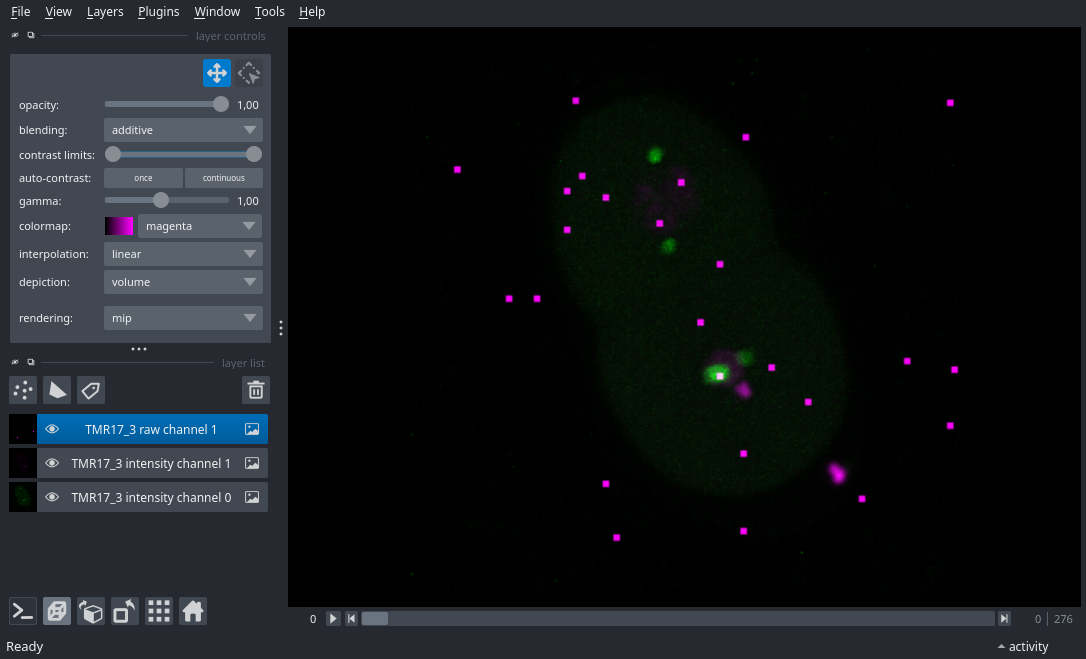

In [15]:
nbscreenshot(viewer)

### Calculate Phasor Plot
Generate the phasor plot with specified settings.
Optionally, do this manually by openning the Calculate Phasors widget from napari-flim-phasor-plotter and run with the same settings.

In [16]:
# Get widget instance
plot_maker_widget = make_flim_phasor_plot()
# Run plot maker widget
phasor_plot_widget, labels_layer = plot_maker_widget(image_layer = viewer.layers[(sample_name + ' raw channel 1')],
                          laser_frequency = laser_frequency,
                          harmonic = harmonic,
                          threshold = threshold,
                          apply_median = True,
                          median_n = median_filter_iteration,
                          napari_viewer = viewer)

/home/pol_haase/mazo260d/miniforge3/envs/lifetime-env2/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


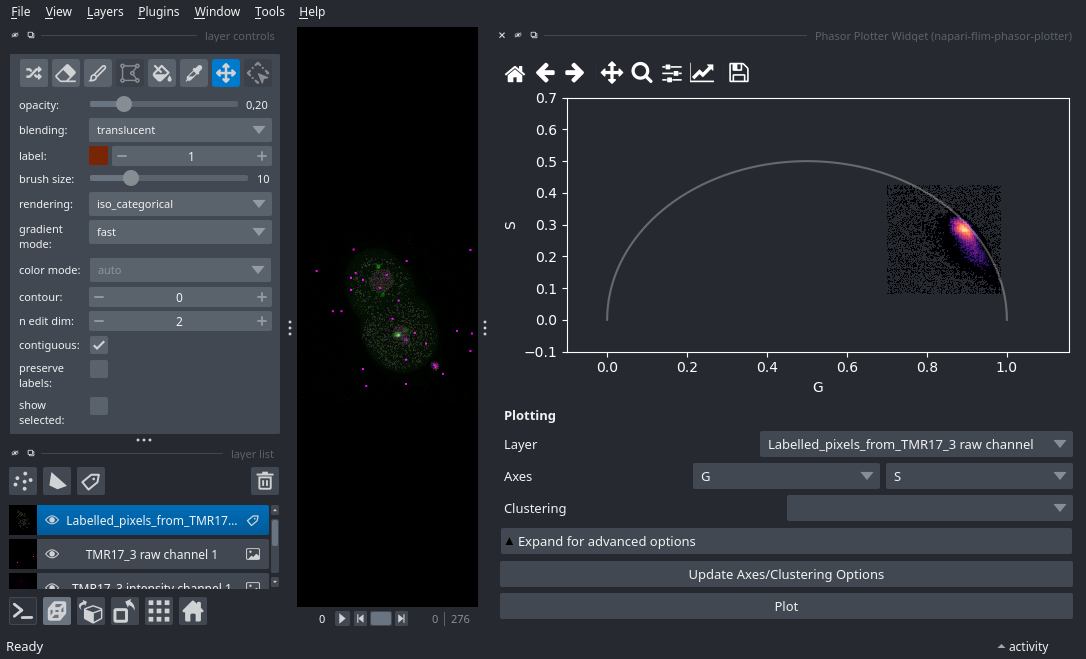

In [17]:
nbscreenshot(viewer)

### Optimize clusters visualization

Set number of bins to 400 (small cluster becomes more visible). Click on Expand for advanced options, uncheck `Auto` in 'Number of bins' and set it to 400.

In [18]:
phasor_plot_widget.bin_auto.setChecked(False)
phasor_plot_widget.bin_number_spinner.setValue(bins)
phasor_plot_widget.bin_number_set.clicked.emit(True)

Zoom in to the region of interest in the plot (optional). Use the zoom tool from the toolbar at the top of the plotter (don't forget to disable it after using it).

In [19]:
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

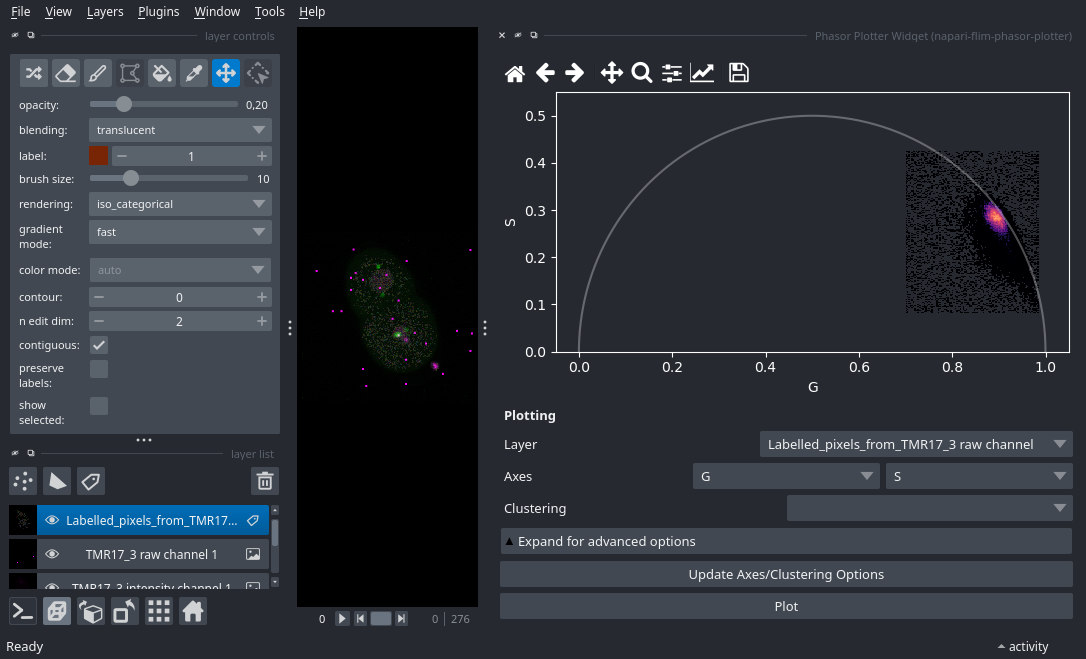

In [20]:
nbscreenshot(viewer)

### Save plot before cluster selection

In [21]:
output_path = Path(zarr_data_path).parent / 'Outputs'
output_path.mkdir(exist_ok=True)
phasor_plot_widget.graphics_widget.axes.figure.savefig(output_path / f'{sample_name}_phasor_plot.png', dpi=300)

### Set an ellipse selection
Given center coordinates and major and minor axis, set an ellipse selection.

In [22]:
# Set center, major axis, minor axis length and angle of ellipse
vertices = ellipse_vertices(center, major, minor, angle)

In [23]:
phasor_plot_widget.graphics_widget.selector.onselect(vertices)
vertices_array = np.array(vertices)
phasor_plot_widget.graphics_widget.axes.plot(vertices_array[:,0], vertices_array[:,1], 'w--')
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

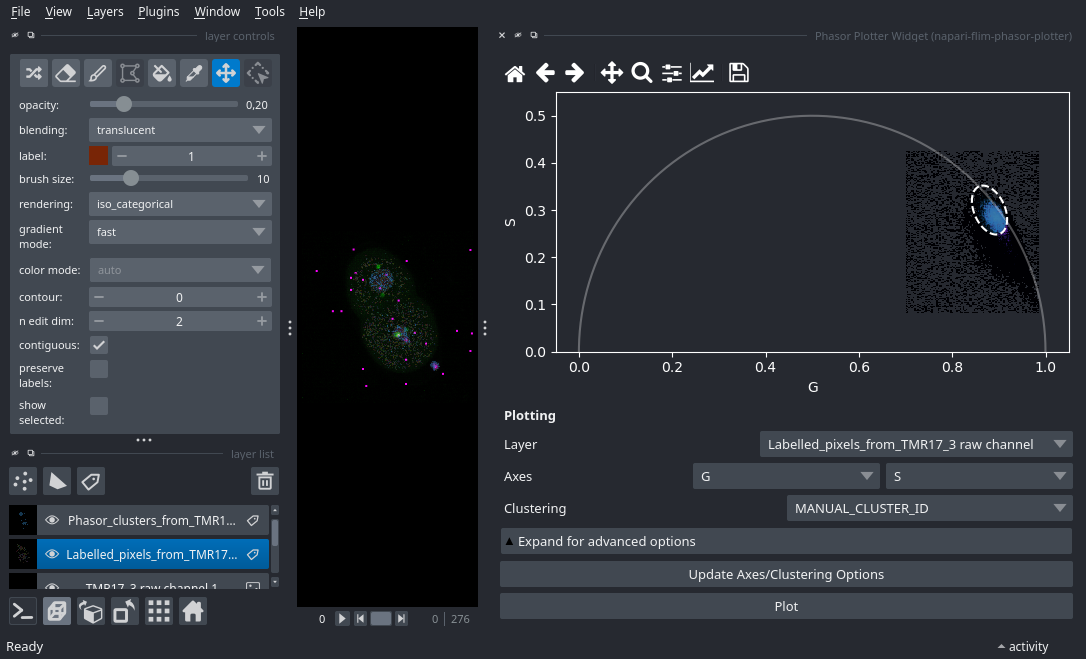

In [24]:
nbscreenshot(viewer)

### Save plot after cluster selection

In [25]:
output_path = Path(zarr_data_path).parent / 'Outputs'
output_path.mkdir(exist_ok=True)
phasor_plot_widget.graphics_widget.axes.figure.savefig(output_path / f'{sample_name}_phasor_plot_after_cluster_selection.png', dpi=300)

## Cluster Labels Post-Processing
### Extract selected cluster mask

In [26]:
extraced_labels_layer = manual_label_extract(
    cluster_labels_layer=phasor_plot_widget.visualized_layer, 
    label_number=2)
cluster_mask_image = extraced_labels_layer.data

### Smooth selected cluster mask

In [27]:
cluster_mask_layer_smoothed = smooth_cluster_mask(
    cluster_mask_layer = extraced_labels_layer,
    fill_area_px = fill_area_px,
    smooth_radius = smooth_radius)

### Instance segmentation on smoothed cluster mask

In [28]:
cluster_labels_image = label(cluster_mask_layer_smoothed.data)
# Hide cluster mask layer
viewer.layers[-1].visible = False
viewer.add_labels(cluster_labels_image, name=(sample_name + ' cluster labels'), opacity=0.5)

<Labels layer 'TMR17_3 cluster labels' at 0x7fc6e28191c0>

## Exclude labels smaller than 900 pixels in volume

In [29]:
cluster_labels_image_filtered = cle.exclude_small_labels(cluster_labels_image, maximum_size=min_allowed_object_size)
# Hide cluster labels layer
viewer.layers[-1].visible = False
viewer.add_labels(cluster_labels_image_filtered, name=(sample_name + ' cluster labels filtered'), opacity=0.5)

<Labels layer 'TMR17_3 cluster labels filtered' at 0x7fc6dccdbeb0>

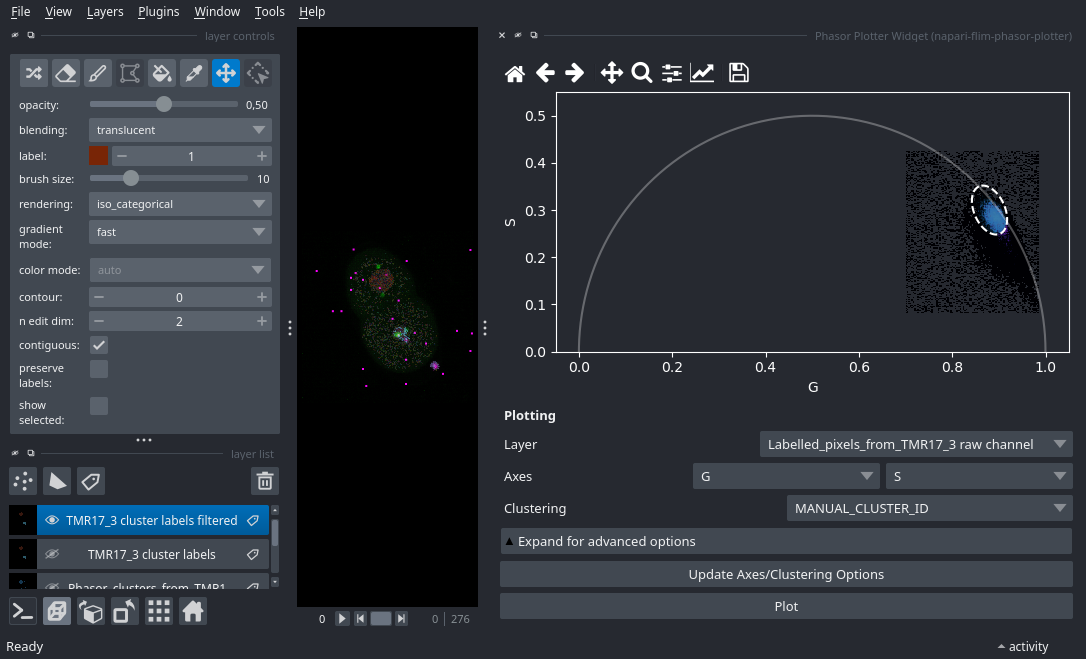

In [30]:
nbscreenshot(viewer)

### Feature Extraction

In [31]:
table = pd.DataFrame(regionprops_table(cluster_labels_image_filtered, properties=('label', 'area', 'centroid')))
table['frame'] = timepoint
table['sample'] = sample_name
table

,label,area,centroid-0,centroid-1,centroid-2,frame,sample
0,1,14373.0,25.551520,73.291588,118.581716,13,TMR17_3
1,2,4186.0,27.029145,153.499044,148.201863,13,TMR17_3
2,3,1477.0,41.580907,200.341909,197.962762,13,TMR17_3


## Save segmentation result and features table

In [32]:
# save stack with tifffile
tifffile.imsave(output_path / f'{sample_name}_cluster_labels.tif', cluster_labels_image_filtered.astype(np.uint8), imagej=True)

4 warnings generated.
/tmp/ipykernel_283190/2229041999.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(output_path / f'{sample_name}_cluster_labels.tif', cluster_labels_image_filtered.astype(np.uint8), imagej=True)


In [33]:
table.to_csv(output_path / f'{sample_name}_cluster_labels.csv', index=False)

### Save current configuration variables

In [34]:
# File path for the config file
file_path = output_path / f'{sample_name}_config.txt'

# Writing to the file
with open(file_path, 'w') as file:
    file.write(f"sample_name = {sample_name}\n")
    file.write(f"timepoint = {timepoint}\n")
    file.write(f"center = {center}\n")
    file.write(f"major-axis = {major}\n")
    file.write(f"minor-axis = {minor}\n")
    file.write(f"angle = {angle}\n")
    file.write(f"bins = {bins}\n")
    file.write(f"x_lim = {x_lim}\n")
    file.write(f"y_lim = {y_lim}\n")
    file.write(f"threshold = {threshold}\n")
    file.write(f"median_filter_iteration = {median_filter_iteration}\n")
    file.write(f"harmonic = {harmonic}\n")
    file.write(f"binning = {binning}\n")
    file.write(f"binning_kernel_size = {binning_kernel_size}\n")
    file.write(f"binning_3D = {binning_3D}\n")
    file.write(f"fill_area_px = {fill_area_px}\n")
    file.write(f"smooth_radius = {smooth_radius}\n")
    file.write(f"min_allowed_object_size = {min_allowed_object_size}\n")

## Packages Versions and Machine Info

In [36]:
%watermark -v -m --gpu -p napari,numpy,napari_flim_phasor_plotter,pyclesperanto_prototype,tifffile,pandas,skimage

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.18.1

napari                    : 0.5.5
numpy                     : 1.23.5
napari_flim_phasor_plotter: 0.1.2
pyclesperanto_prototype   : 0.24.5
tifffile                  : 2022.8.12
pandas                    : 2.2.3
skimage                   : 0.24.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 5.15.0-25-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

GPU Info: 
  GPU 0: NVIDIA RTX 6000 Ada Generation
  GPU 1: NVIDIA RTX 6000 Ada Generation

